a start-up that lists properties on behalf of Airbnb hosts.

**Data Description:**
1.	dataset airbnb_listings_information.csv includes the details for a sample of historic Airbnb listings for London.
2.	data_dictionary_airbnb.xlsx data dictionary describing the fields within the dataset. 

**Problem Statement:**
The firm intends to use a model to advise their clients on how to set a competitive price for their first listing on Airbnb. The model must predict the expected price of a new listing using at least the features of the property itself (including location and amenities) and listing parameters (e.g. min nights, accommodates and availabilities). 

**Objective:**
To prepare a model to advise the clients to set competitive price for their first listing on Airbnb based on the features of the property (including location and amenities) and listing parameters (e.g. min nights, accommodates and availabilities). 


In [1]:
# Import Package and Data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch   # Used for reordering the correlation matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error,mean_absolute_error
import math,time,joblib
from datetime import datetime
import string,re
from scipy.stats import mstats

import sklearn 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Data Acquisition

In [2]:
#define path of data folder and read dataset
data_path = 'D:/'

data = pd.read_csv(data_path+'airbnb_listings_information.csv', encoding = 'utf8')

In [3]:
#sample data
data.head()

,Unnamed: 0,neighborhood_overview,host_name,host_location,host_about,host_response_time,host_verifications,neighbourhood,property_type,room_type,amenities,host_is_superhost,accommodates,bedrooms,beds,price,minimum_nights,number_of_reviews,review_scores_rating,instant_bookable
0,0,Not even 10 minutes by metro from Victoria Sta...,Adriano,"London, England, United Kingdom","Hello, I'm a friendly Italian man with a very ...",within an hour,"['email', 'phone', 'reviews', 'jumio', 'offlin...","London, United Kingdom",Entire apartment,Entire home/apt,"[""Refrigerator"", ""Kitchen"", ""Crib"", ""Dedicated...",0,4,1,3,105.0,2,192,91.0,1
1,1,Finsbury Park is a friendly melting pot commun...,Alina,"London, England, United Kingdom",I am a Multi-Media Visual Artist and Creative ...,within a few hours,"['email', 'phone', 'facebook', 'reviews', 'off...","Islington, Greater London, United Kingdom",Private room in apartment,Private room,"[""Long term stays allowed"", ""Lock on bedroom d...",0,2,1,1,40.0,1,21,97.0,0
2,2,It is Chelsea.,Philippa,"Kensington, England, United Kingdom","English, grandmother, I have travelled quite ...",NaN,"['email', 'phone', 'reviews', 'jumio', 'govern...","London, United Kingdom",Entire apartment,Entire home/apt,"[""Refrigerator"", ""Wifi"", ""Heating"", ""Dishes an...",0,2,1,1,75.0,10,89,96.0,1
3,3,"Location, location, location! You won't find b...",Liz,"London, England, United Kingdom",We are Liz and Jack. We manage a number of ho...,a few days or more,"['email', 'phone', 'reviews', 'jumio', 'offlin...","London, Fitzrovia, United Kingdom",Entire apartment,Entire home/apt,"[""Long term stays allowed"", ""Elevator"", ""Heati...",1,6,3,3,307.0,4,42,94.0,0
4,4,Fulham is 'villagey' and residential – a real ...,Charlotte,"London, England, United Kingdom","Named best B&B by The Times. Easy going hosts,...",NaN,"['email', 'phone', 'jumio', 'selfie', 'governm...","London, United Kingdom",Private room in townhouse,Private room,"[""TV"", ""Hair dryer"", ""Lock on bedroom door"", ""...",0,2,1,1,150.0,3,0,NaN,0


# Data Preprocessing

In [4]:
# remove redundant index, host_name and host_about
data = data.drop(['Unnamed: 0','host_name','host_about'],axis=1)

In [5]:
# Shape of dataset
data.shape

(76606, 17)

In [6]:
#featureset
data.columns

Index(['neighborhood_overview', 'host_location', 'host_response_time',
       'host_verifications', 'neighbourhood', 'property_type', 'room_type',
       'amenities', 'host_is_superhost', 'accommodates', 'bedrooms', 'beds',
       'price', 'minimum_nights', 'number_of_reviews', 'review_scores_rating',
       'instant_bookable'],
      dtype='object')

In [7]:
#check duplicate data
data.duplicated().sum()

251

In [8]:
# Remove duplicate data
data = data.drop_duplicates()

In [9]:
# check missing data
data.isnull().sum()

neighborhood_overview    29236
host_location              180
host_response_time       39634
host_verifications           0
neighbourhood            29235
property_type                0
room_type                    0
amenities                    0
host_is_superhost            0
accommodates                 0
bedrooms                     0
beds                         0
price                        0
minimum_nights               0
number_of_reviews            0
review_scores_rating     23704
instant_bookable             0
dtype: int64

### Handle Missing Data

In [10]:
#fill missing records by 0 for review_scores_rating
data['review_scores_rating'] = data['review_scores_rating'].fillna(0)

In [11]:
#fill missing records by 'No Overview' for neighborhood_overview
data['neighborhood_overview'] = data['neighborhood_overview'].fillna('No Overview')

In [12]:
#datatype change and fill missing host_location record by 'Other'
data['host_location'] = data['host_location'].replace('...',np.NaN)
data['host_location'] = data['host_location'].fillna('Other').apply(str)

In [13]:
#fill missing records by 'unknown' for host_response_time
data['host_response_time'] = data['host_response_time'].fillna('unknown')

In [14]:
#fill missing records by 'Other' for neighbourhood
data['neighbourhood'] = data['neighbourhood'].fillna('Other')

In [15]:
# Dataset Information
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76355 entries, 0 to 76605
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   neighborhood_overview  76355 non-null  object 
 1   host_location          76355 non-null  object 
 2   host_response_time     76355 non-null  object 
 3   host_verifications     76355 non-null  object 
 4   neighbourhood          76355 non-null  object 
 5   property_type          76355 non-null  object 
 6   room_type              76355 non-null  object 
 7   amenities              76355 non-null  object 
 8   host_is_superhost      76355 non-null  int64  
 9   accommodates           76355 non-null  int64  
 10  bedrooms               76355 non-null  int64  
 11  beds                   76355 non-null  int64  
 12  price                  76355 non-null  float64
 13  minimum_nights         76355 non-null  int64  
 14  number_of_reviews      76355 non-null  int64  
 15  re

We have total 76606 records includes the details for a sample of historic Airbnb listings for London data with 19 features ('neighborhood_overview', 'host_name', 'host_location', 'host_about','host_response_time', 'host_verifications', 'neighbourhood','property_type', 'room_type', 'amenities', 'host_is_superhost','accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights','number_of_reviews', 'review_scores_rating', 'instant_bookable'). 

After removing redundant index, host_name and host_about, there is 17 features.

Where we explore 251 data records has duplicated values and handle this redundancy by remove duplicate data.

There are following features has NaN records:
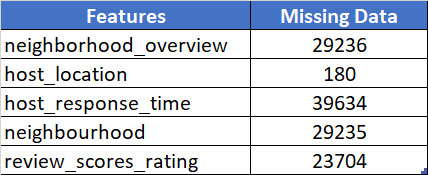

Handled missing data filling by 0 for review_scores_rating, by 'No Overview' for neighborhood_overview, host_location record by 'Other', by 'unknown' for host_response_time,by 'Other' for neighbourhood


### Descriptive Analysis 

In [16]:
data.describe()

,host_is_superhost,accommodates,bedrooms,beds,price,minimum_nights,number_of_reviews,review_scores_rating,instant_bookable
count,76355.000000,76355.000000,76355.000000,76355.000000,76355.000000,76355.000000,76355.000000,76355.000000,76355.000000
mean,0.142676,3.063035,1.457626,1.737542,107.382560,5.110549,15.343370,64.157829,0.361980
std,0.349744,1.931230,0.833475,1.211333,122.284051,21.328224,35.541443,43.929455,0.480576
min,0.000000,1.000000,1.000000,1.000000,7.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,1.000000,1.000000,44.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,2.000000,1.000000,1.000000,75.000000,2.000000,3.000000,91.000000,0.000000
75%,0.000000,4.000000,2.000000,2.000000,125.000000,4.000000,14.000000,98.000000,1.000000
max,1.000000,16.000000,12.000000,27.000000,3872.000000,1125.000000,817.000000,100.000000,1.000000


In [17]:
# Get all numeric columns
numeric_columns = list(data.select_dtypes(include=[np.number]).columns)

numeric_columns.remove('instant_bookable') # Because of categorical feature
numeric_columns.remove('host_is_superhost') # Because of categorical feature
numeric_columns

['accommodates',
 'bedrooms',
 'beds',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'review_scores_rating']

In [18]:
#function to calculate interquartile range
def find_iqr(x):
    return np.subtract(*np.percentile(x, [75, 25]))

numeric_df = data[numeric_columns]

#calculate Median,Mode,Distinct, IQR for all columns
print(pd.concat([numeric_df.median(),numeric_df.mode().iloc[0],numeric_df.nunique(),numeric_df.apply(find_iqr),numeric_df.sum()], axis=1, keys=['Median', 'Mode','Distinct','IQR','Sum']))

                      Median  Mode  Distinct   IQR         Sum
accommodates             2.0   2.0        16   2.0   233878.00
bedrooms                 1.0   1.0        12   1.0   111297.00
beds                     1.0   1.0        22   1.0   132670.00
price                   75.0  50.0       824  81.0  8199195.37
minimum_nights           2.0   1.0       120   3.0   390216.00
number_of_reviews        3.0   0.0       407  14.0  1171543.00
review_scores_rating    91.0   0.0        54  98.0  4898771.00


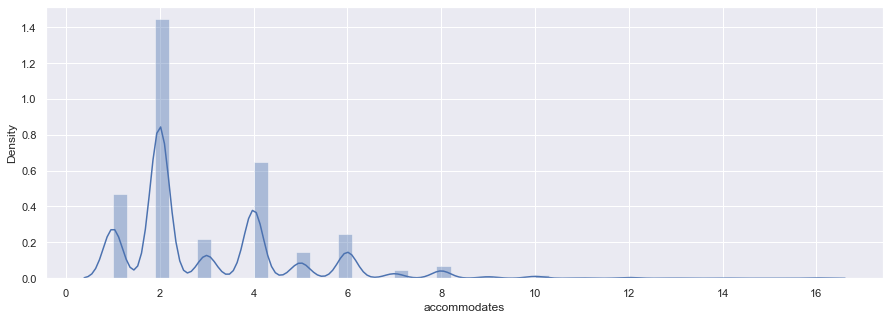

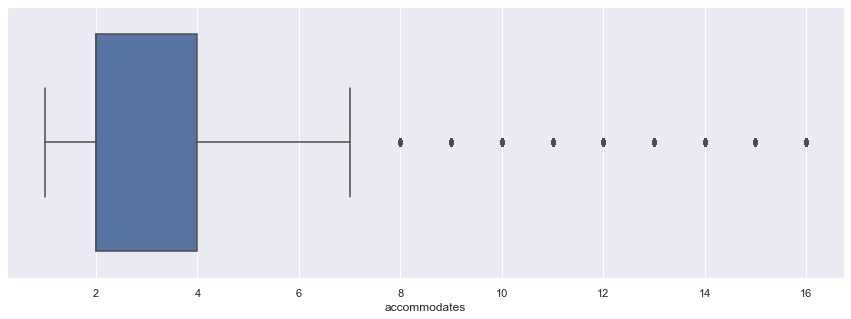

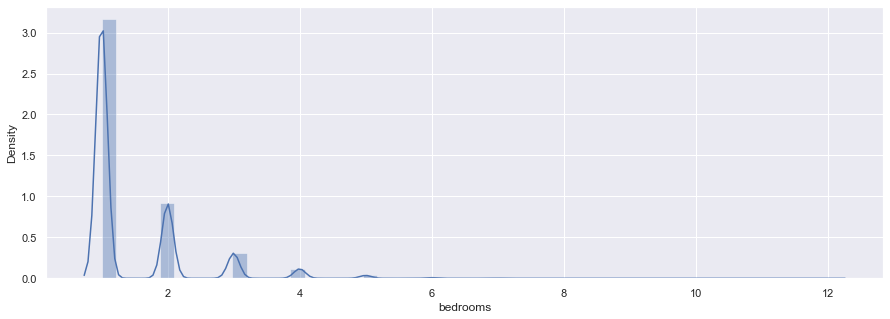

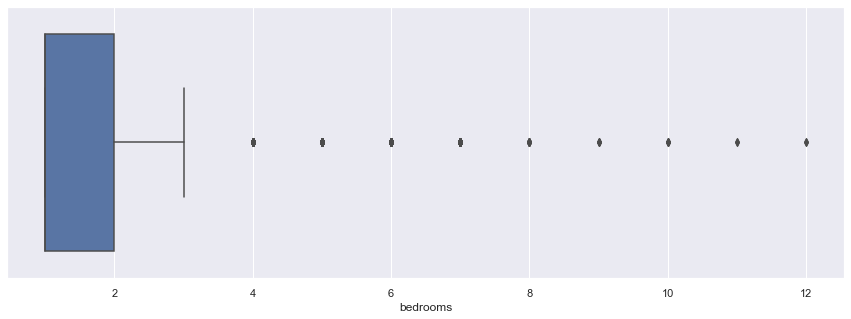

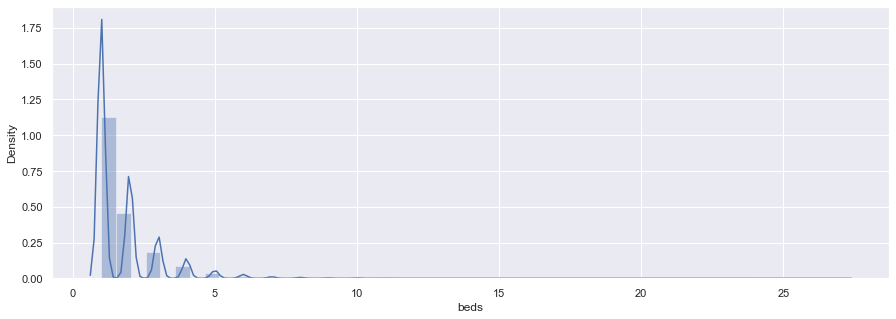

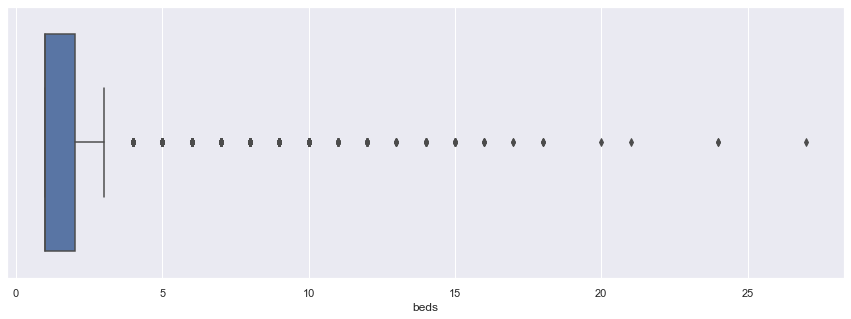

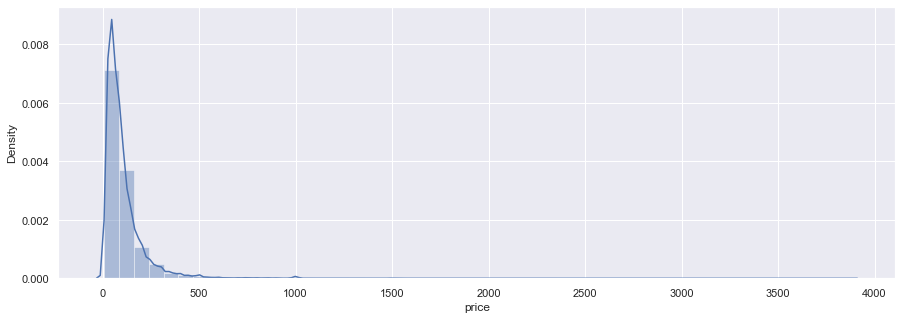

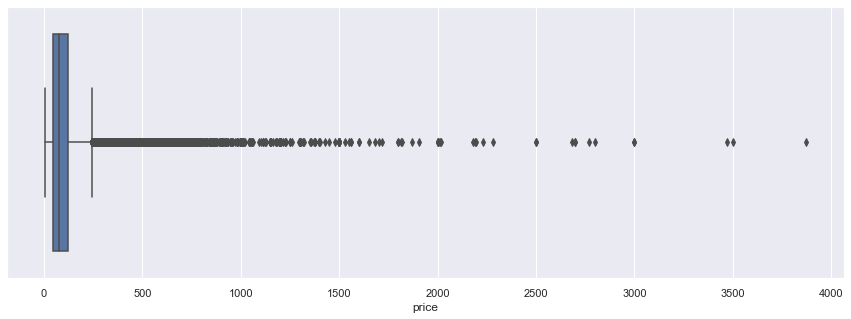

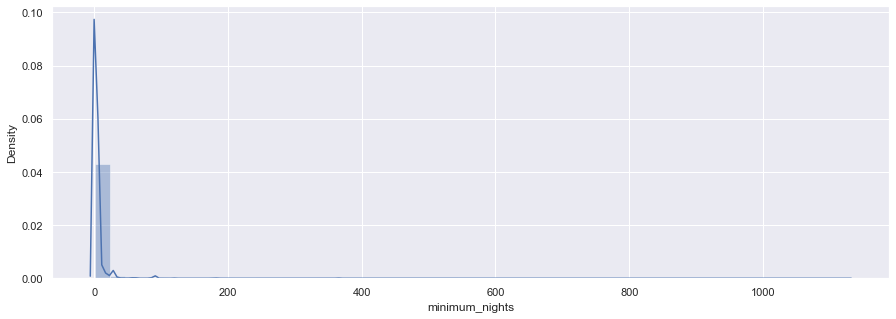

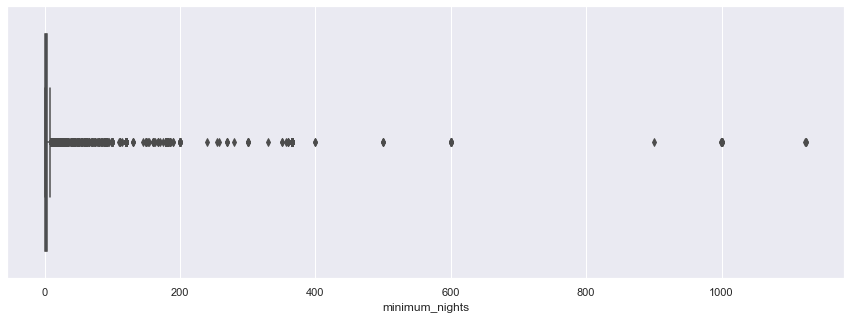

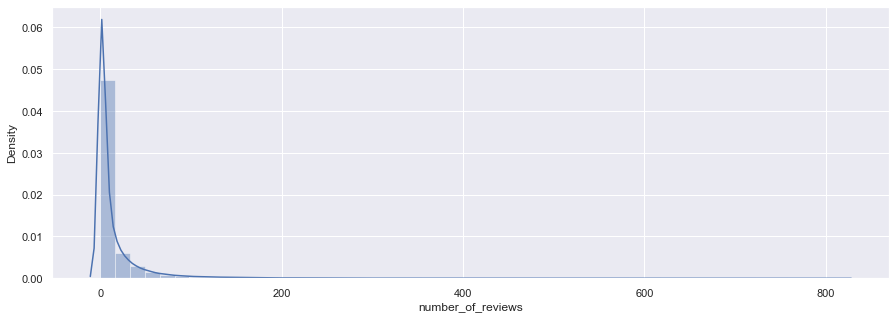

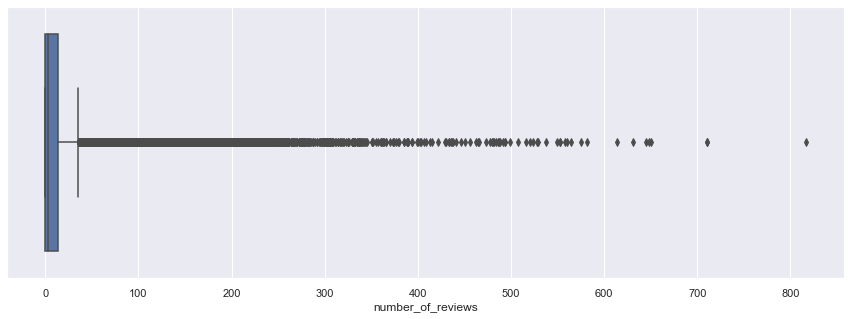

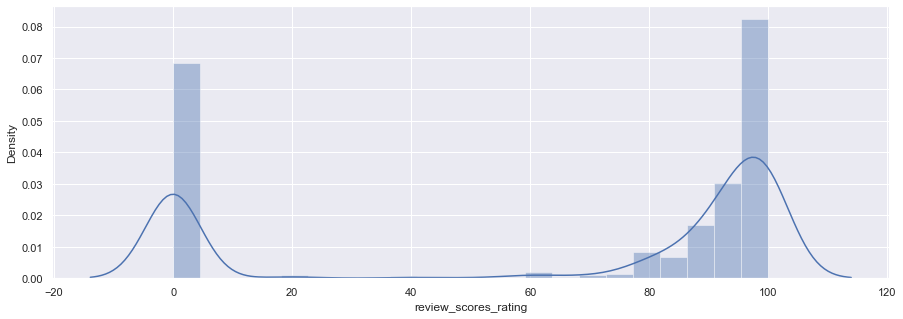

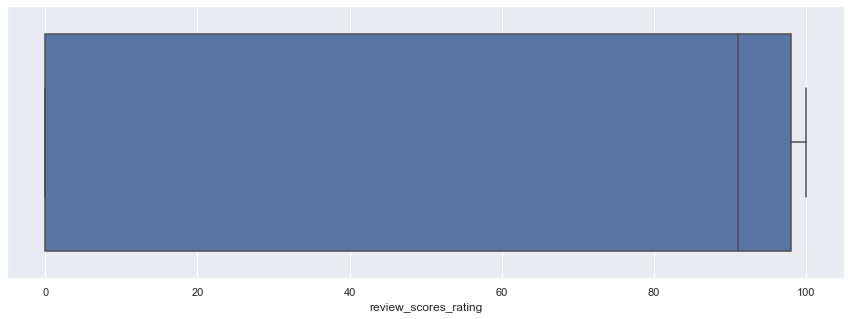

accommodates            None
bedrooms                None
beds                    None
price                   None
minimum_nights          None
number_of_reviews       None
review_scores_rating    None
dtype: object


In [19]:
#Plot histogram is a representation of the distribution of dataset.
sns.set(rc={'figure.figsize':(15,5)})

#Explore Top values from Features
def find_distribution(x):
    sns.set(rc={'figure.figsize':(15,5)})
    sns.distplot(x)
    plt.show()
    
    sns.boxplot(x)
    plt.show()
    
    
print(numeric_df.apply(find_distribution))

In [20]:
# number of property price below 500 GBP.
data[data['price'] <= 500]['price'].size

75438

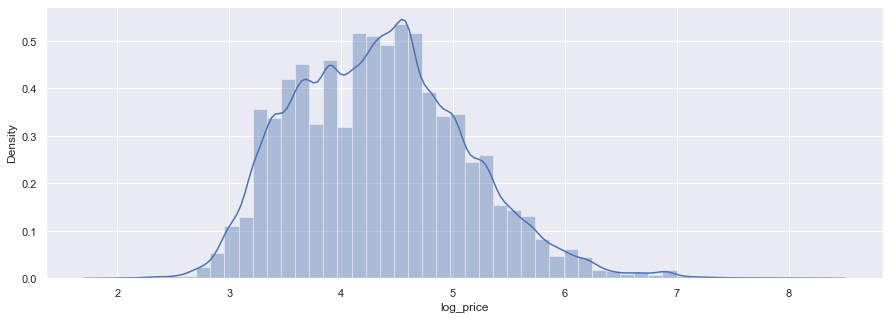

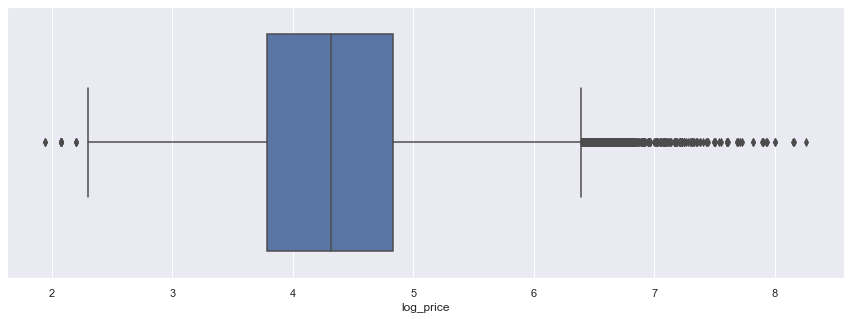

In [21]:
data['log_price'] = np.log(data.price)
find_distribution(data['log_price'])

In [22]:
# price per bedrooms
data['price_per_room'] = (data.price) / (data.bedrooms)

In [23]:
#remove outliers from log_price feature
data['log_price'] = mstats.winsorize(data['log_price'], limits=[0.02, 0.02])

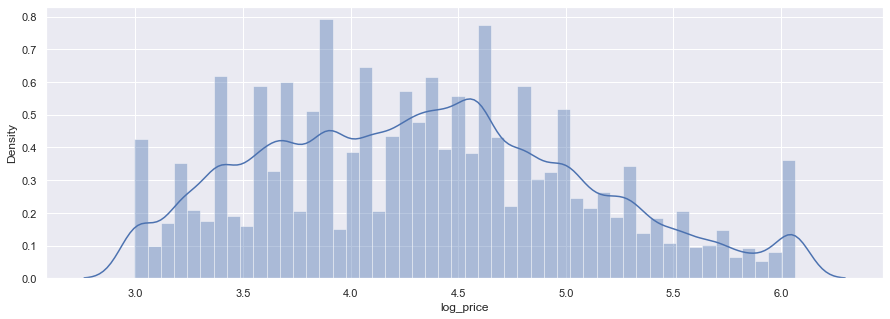

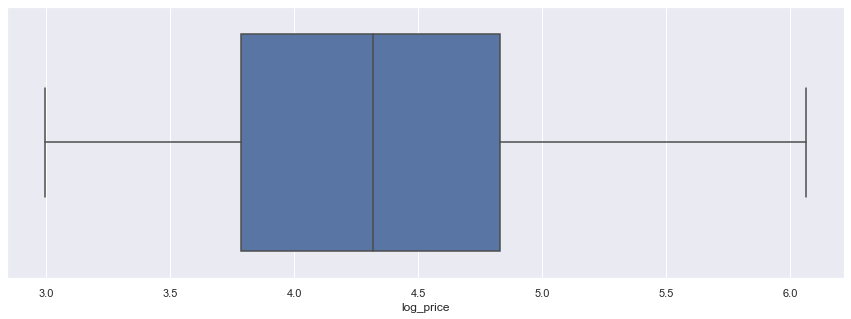

In [24]:
find_distribution(data['log_price'])

In [25]:
#number of people the property accomodates
data['accommodates'].value_counts(normalize=True)

2     0.432558
4     0.194578
1     0.140999
6     0.074180
3     0.065091
5     0.043743
8     0.020994
7     0.013044
10    0.005291
9     0.004191
12    0.002174
16    0.000956
11    0.000812
14    0.000550
13    0.000471
15    0.000367
Name: accommodates, dtype: float64

In [26]:
# remove outliers from accommodates
data['accommodates'] = mstats.winsorize(data['accommodates'], limits=[0.04, 0.04])

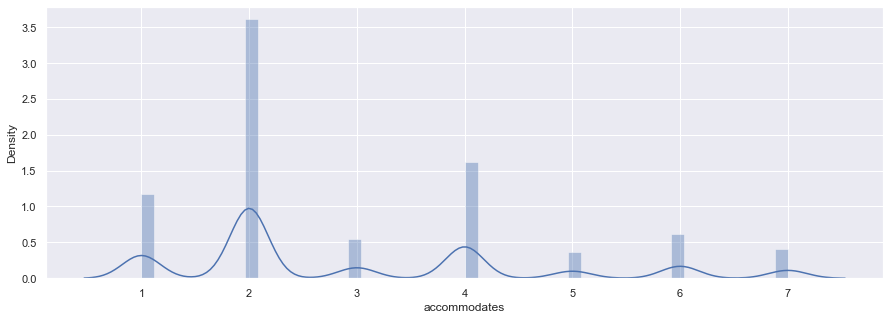

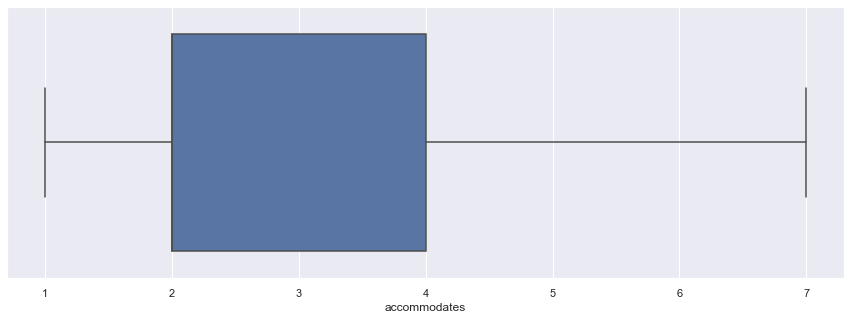

In [27]:
find_distribution(data['accommodates'])

In [28]:
# the number of bedrooms the property has
data['bedrooms'].value_counts(normalize=True)

1     0.695305
2     0.201441
3     0.067605
4     0.025486
5     0.007701
6     0.001729
7     0.000432
8     0.000131
10    0.000065
9     0.000052
11    0.000026
12    0.000026
Name: bedrooms, dtype: float64

In [29]:
# remove outliers from bedrooms
data['bedrooms'] = mstats.winsorize(data['bedrooms'], limits=[0.04, 0.04])

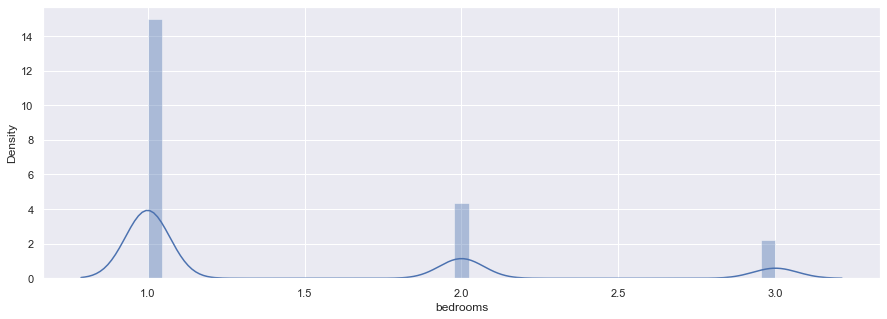

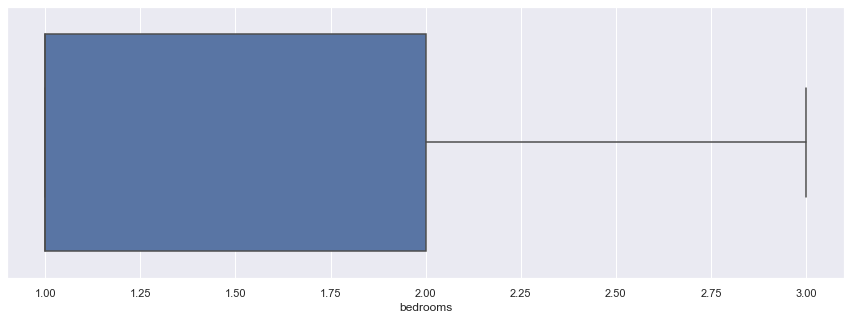

In [30]:
find_distribution(data['bedrooms'])

In [31]:
# the number of beds the property has
data['beds'].value_counts(normalize=True)

1     0.586589
2     0.238360
3     0.096392
4     0.044280
5     0.017903
6     0.008683
7     0.003444
8     0.001951
9     0.000786
10    0.000747
11    0.000210
12    0.000196
14    0.000105
15    0.000105
13    0.000065
16    0.000052
18    0.000039
17    0.000026
24    0.000026
20    0.000013
21    0.000013
27    0.000013
Name: beds, dtype: float64

In [32]:
# remove outliers from beds
data['beds'] = mstats.winsorize(data['beds'], limits=[0.08, 0.08])

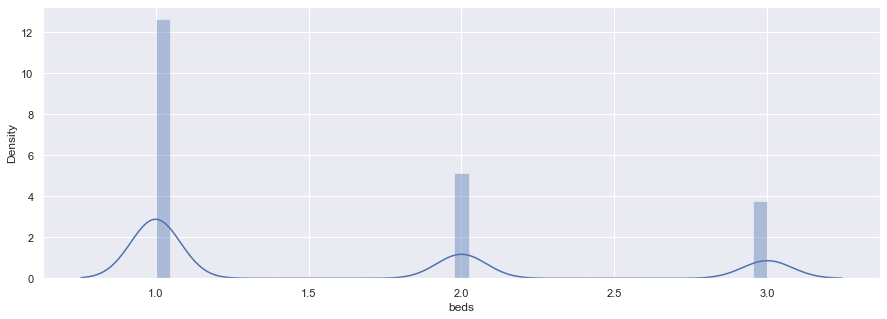

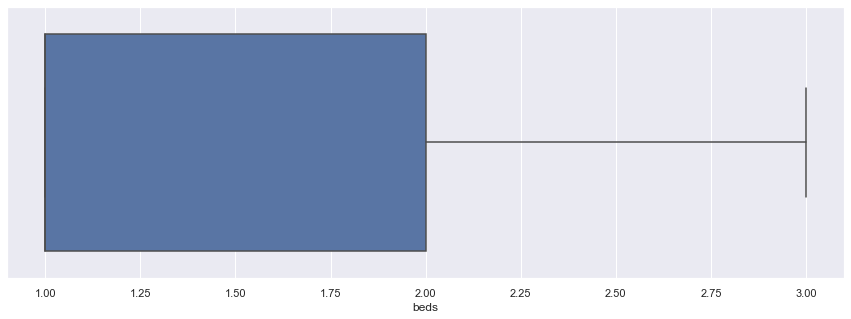

In [33]:
find_distribution(data['beds'])

In [34]:
#the number of reviews the host has received from renters.
data['number_of_reviews'].value_counts(normalize=True)

0      0.287866
1      0.119848
2      0.070395
3      0.050815
4      0.038059
         ...   
520    0.000013
430    0.000013
280    0.000013
336    0.000013
413    0.000013
Name: number_of_reviews, Length: 407, dtype: float64

In [35]:
# remove outliers from number_of_reviews
data['number_of_reviews'] = mstats.winsorize(data['number_of_reviews'], limits=[0.12, 0.12])

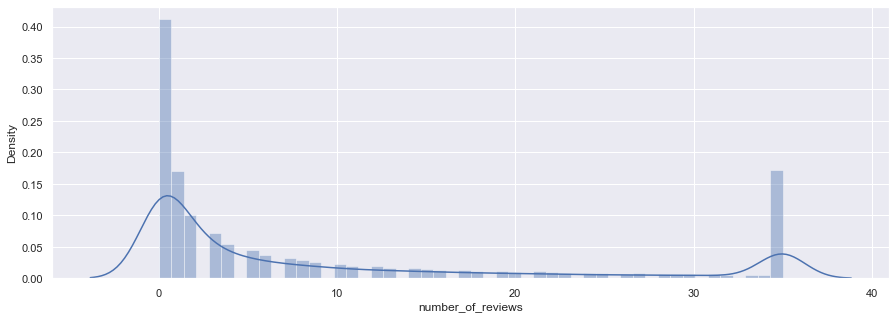

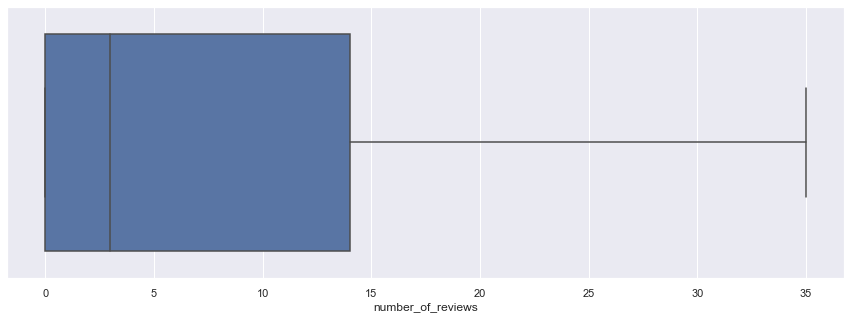

In [36]:
find_distribution(data['number_of_reviews'])

In [37]:
#the minimum number of nights for a single stay
data['minimum_nights'].value_counts(normalize=True)

1      0.321551
2      0.271547
3      0.156584
4      0.057167
5      0.056041
         ...   
69     0.000013
64     0.000013
79     0.000013
63     0.000013
240    0.000013
Name: minimum_nights, Length: 120, dtype: float64

In [38]:
# remove outliers from minimum nights
data['minimum_nights'] = mstats.winsorize(data['minimum_nights'], limits=[0.08, 0.08])

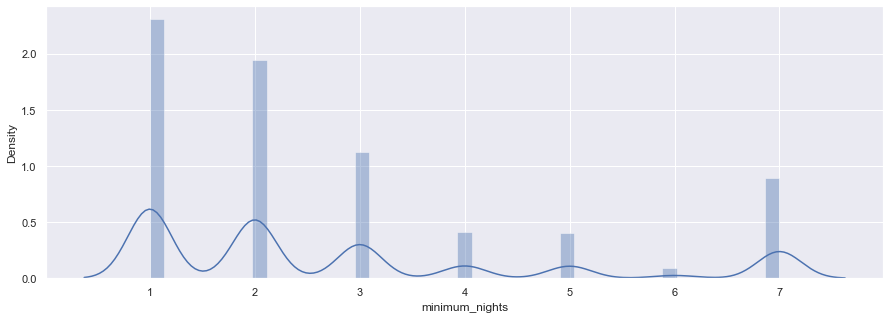

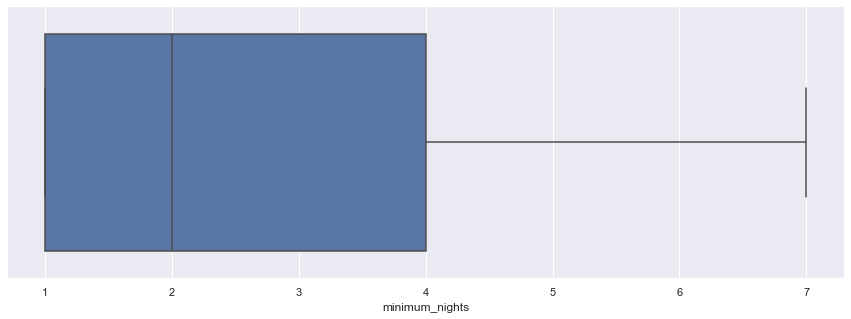

In [39]:
find_distribution(data['minimum_nights'])

- 75438 properties 'price' are between range 0-500 GBP. However, Prices are greatly skewed to the right. This causes a non-linear relationship between the price and features. We take the natural logarithm of the price to make the effective relationship non-linear, while still preserving the linear model. After taking price log we detect the outliers and handle outliers using winsorize method and set new limits.
- According to the Data Distribution and the boxplot, we explored the 'accommodates' has some outliers (e.g., 8 to 16). Because the property records are less with the range of 8-16 people as compared to other accommodates count.
- 1-3 'bedrooms' properties are highly available as compared to 4 or more than 'bedrooms' properties. With the 1-3 'beds' properties are highly available as compared to 4 or more than 'beds' properties same case as 'bedrooms'. Bedrooms and Beds features has same impact on the model. Therefore, we can choose one.
- property host allows for 1 to 240 'minimum_nights' stay. Whereas 32.16% host allows for 1 and 27.15% host allows for 2 minimum_nights stay.
- 28.79% of host has 0 number_of_reviews. However, different host has different number_of_reviews.

# Feature Engineering

In [40]:
import spacy
nlp_en = spacy.load('en_core_web_lg')
#!python -m spacy download en_core_web_lg

from geotext import GeoText
#! pip install geotext

def extract_location(text):
    nearby_location = ','.join([ent.text for ent in nlp_en(text).ents if ent.label_ in ['FAC','ORG','LOC','GPE']])
    return nearby_location

In [41]:
# remove punctuations
data['neighborhood_overview'] = data['neighborhood_overview'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation+'–'), '' , str(x)))

#replace Contractions
data['neighborhood_overview'] =data['neighborhood_overview'].str.replace('’s','')

# extract nearby_location from neighborhood_overview
data['nearby_location'] = data['neighborhood_overview'].apply(extract_location)

# list_of_nearby_location and counts
data['list_of_nearby_location'] = data['nearby_location'].str.split(',')
data['number_of_nearby'] = data['list_of_nearby_location'].str.len()

# remove redundant features
data = data.drop(['neighborhood_overview','nearby_location','list_of_nearby_location'],axis=1)

In [42]:
def extract_country(text):
    if 'United Kingdom' in text.split(', '):
        return 'Native'
    else:
        return 'Aboard'

def extract_city(text):
    if 'London' in text.split(', '):
        return 'London'
    else:
        return 'Other'

In [43]:
# Host Location Status by country and city
data['host_country_status'] = data['host_location'].apply(extract_country)
data['host_city_status'] = data['host_location'].apply(extract_city)

# remove redundant features
data = data.drop(['host_location'],axis=1)

In [44]:
data['host_country_status'].value_counts(normalize=True)

Native    0.703726
Aboard    0.296274
Name: host_country_status, dtype: float64

In [45]:
data['host_city_status'].value_counts(normalize=True)

London    0.593098
Other     0.406902
Name: host_city_status, dtype: float64

According to the dataset 70.37% Host lives in United Kingdom. Where, 59.30% of Native Host lives in London.

In [46]:
def extract_reponse_time(text):
    if 'hour' in text.split(' '):
        response_time = 'hour'
    elif 'hours' in text.split(' '):
        response_time = 'hours'
    elif 'days' in text.split(' '):
        response_time = 'days'
    elif 'day' in text.split(' '):
        response_time = 'day'
    else:
        response_time = 'unknown'
    return response_time

data['host_response_time'] = data['host_response_time'].apply(extract_reponse_time)

In [47]:
# host_verifications status
data['host_verifications'] = data['host_verifications'].replace('[]',np.nan)
data.loc[data['host_verifications'].isnull(), 'host_verifications_status'] = 'Verified'  
data.loc[~data['host_verifications'].isnull(), 'host_verifications_status'] = 'Not Verified'  

# remove redundant features
data = data.drop(['host_verifications'],axis=1)

data['host_verifications_status'].value_counts(normalize=True)

Not Verified    0.999044
Verified        0.000956
Name: host_verifications_status, dtype: float64

99.90% of Host accounts are not Verified

In [48]:
#neighbourhood town and Property_Location
data['neighbourhood_town'] = data['neighbourhood'].str.split(', ').str[0]

data['neighbourhood_town'] = data['neighbourhood_town'].fillna('Other')
data['neighbourhood_town'] = data['neighbourhood_town'].str.lower()
data['neighbourhood_town'] = data['neighbourhood_town'].str.strip()

replacement = {
    "  ":' ',
    "’|'|/|\*|`|\.|-": ""
}

loc_bow = {
    'woordford green':'woodford green',
    'united kingdom':np.nan,
    'south woodform':'south woodford',
    'south kensington station':'south kensington',
    'queens park  london':'queens park',
    'peckham london':'peckham',
    'mitcham junction':'mitcham',
    'londyn|londres|londre|londra|londond':'london',
    'kingstonuponthames':'kingston upon thames',
    'hanwell london':'hanwell',
    'hammersmith london':'hammersmith',
    'england':np.nan,
    'ealing london':'ealing',
    'dalston london|dalston junction':'dalston',
    'crouch end london':'crouch end',
    'chelsea london':'chelsea'
}

data['neighbourhood_town'] = data['neighbourhood_town'].replace(replacement, regex=True)
data.loc[data['neighbourhood_town'].str.contains('london'), 'Property_Location'] = data['neighbourhood_town']  
data.loc[(~data['neighbourhood_town'].str.contains('london'))&(data['neighbourhood_town'].str.replace(' ','').str.isalpha()), 'Property_Location'] = data['neighbourhood_town']
data.loc[(~data['neighbourhood_town'].str.contains('london'))&(~data['neighbourhood_town'].str.replace(' ','').str.isalpha()), 'Property_Location'] =  data['neighbourhood'].str.split(', ').str[1] 
data['Property_Location'] = data['Property_Location'].replace(loc_bow, regex=True)
data['Property_Location'] = data['Property_Location'].fillna('Other')
data.loc[data['Property_Location'] == '', 'Property_Location'] = 'Other'

# remove redundant features
data = data.drop(['neighbourhood','neighbourhood_town'],axis=1)


In [49]:
# amenities distribution and counts
data['amenities'] = data['amenities'].str.lower()
data.loc[data['amenities'].str.contains("tv|video|games|sound"), 'Entertainment'] = '1'  
data.loc[data['amenities'].str.contains("kitchen|refrigerator|microwave|cooking|dishes|silverware|dishwasher|stove|oven"), 'Kitchen and dining'] = '1'  
data.loc[data['amenities'].str.contains("wifi|workspace|ethernet"), 'Internet and office'] = '1'  
data.loc[data['amenities'].str.contains("bath|hair|shampoo|water"), 'Bathroom'] = '1'  
data.loc[data['amenities'].str.contains("washing|dryer|towels|hangers|bed|pillows|blankets|iron"), 'Bedroom and laundry'] = '1'  
data.loc[data['amenities'].str.contains("guards|staff|extinguisher"), 'safety'] = '1'  
data.loc[data['amenities'].str.contains("private entrance|outdoor|garden|beach|parking|pool|pet|air conditioning|alarm"), 'Facilities'] = '1'  
data.loc[data['amenities'].str.contains("fireplace|heating"), 'Heating and cooling'] = '1'  

replacement = {
    '"':' ',
    "\[|\]": ""
}
data['amenities'] = data['amenities'].replace(replacement, regex=True)
data['amenities'] = data['amenities'].str.split(' ,  ')

data['number_of_amenities'] = data['amenities'].str.len()

# handle missing data by fill 0
data['Entertainment'] = data['Entertainment'].fillna('0')
data['Kitchen and dining'] = data['Kitchen and dining'].fillna('0')
data['Internet and office'] = data['Internet and office'].fillna('0')
data['Bathroom'] = data['Bathroom'].fillna('0')
data['Bedroom and laundry'] = data['Bedroom and laundry'].fillna('0')
data['safety'] = data['safety'].fillna('0')
data['Facilities'] = data['Facilities'].fillna('0')
data['Heating and cooling'] = data['Heating and cooling'].fillna('0')

# remove redundant features
data = data.drop(['amenities'],axis=1)

In [50]:
#property_type
data['property'] = data['property_type'].str.lower()

replacement = {
    "entire": "",
    "private": "",
    "room": "",
    "shared": "",
    "in ":""
}

data['property'] = data['property'].replace(replacement, regex=True)
data['property'] = data['property'].str.strip()
data['property'] = data['property'].replace('',"other")

# remove redundant features
data = data.drop(['property_type'],axis=1)

data['property'].value_counts(normalize=True)

apartment             0.655648
house                 0.218558
townhouse             0.032283
condominium           0.026167
serviced apartment    0.017851
loft                  0.008801
bed and breakfast     0.007963
boutique hotel        0.005920
guest suite           0.004806
guesthouse            0.003916
hotel                 0.003890
hostel                0.002986
bungalow              0.001925
aparthotel            0.001532
other                 0.001441
cottage               0.001074
tiny house            0.000943
boat                  0.000851
villa                 0.000629
home/apt              0.000393
houseboat             0.000354
place                 0.000354
cabin                 0.000249
earth house           0.000223
camper/rv             0.000210
chalet                0.000157
hut                   0.000131
floor                 0.000118
yurt                  0.000092
farm stay             0.000079
casa particular       0.000079
barn                  0.000065
dome hou

In [51]:
# apartment property_type analysis
data[data['property']=='apartment']['room_type'].value_counts(normalize=True)

Entire home/apt    0.639327
Private room       0.355100
Shared room        0.005513
Hotel room         0.000060
Name: room_type, dtype: float64

65.56% of properities are available in apartment type.
Where, 63.93% of the properties are entire apartment, 35.51% properties has private room available.

In [52]:
data.columns

Index(['host_response_time', 'room_type', 'host_is_superhost', 'accommodates',
       'bedrooms', 'beds', 'price', 'minimum_nights', 'number_of_reviews',
       'review_scores_rating', 'instant_bookable', 'log_price',
       'price_per_room', 'number_of_nearby', 'host_country_status',
       'host_city_status', 'host_verifications_status', 'Property_Location',
       'Entertainment', 'Kitchen and dining', 'Internet and office',
       'Bathroom', 'Bedroom and laundry', 'safety', 'Facilities',
       'Heating and cooling', 'number_of_amenities', 'property'],
      dtype='object')

- We extracted number of nearby location from neighborhood_overview using Natural Language Processing.
- Host Location Status by country and city from host_location. According to the dataset 70.37% Host lives in United Kingdom. Where, 59.30% of Native Host lives in London.
- host_verifications_status from host_verifications. 99.90% of Host accounts are not Verified
- Property_Location from neighbourhood.
- Extracted Number of amentity, Entertainment, Kitchen and dining, Internet and office, Bathroom, Bedroom and laundry, safety, Facilities, Heating and cooling from amenities.
- price per bedrooms using following formula:
	price_per_room = price / bedrooms
- Property from property_type. 65.56% of properities are available in apartment type. Where, 63.93% of the properties are entire apartment, 35.51% properties has private room available.
- After Feature Engineering data has 32 features.


# Data Exploration

In [53]:
# Percentage of host belong to superhost category
data['host_is_superhost'].value_counts(normalize=True)

0    0.857324
1    0.142676
Name: host_is_superhost, dtype: float64

,price_per_room
host_is_superhost,
0,74.397345
1,70.948514


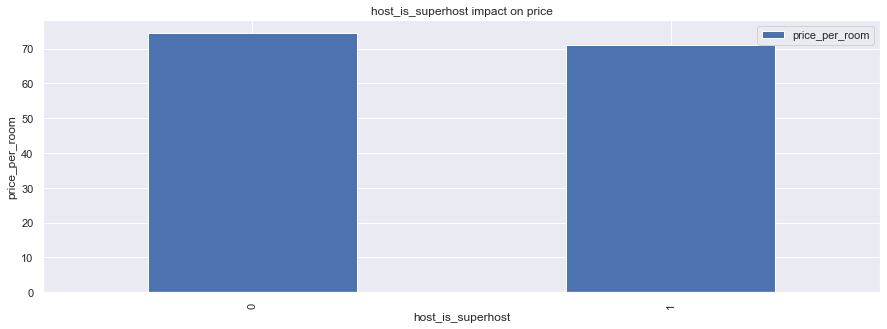

In [54]:
# host_is_superhost impact on property price
property_price = data[['host_is_superhost','price_per_room']].groupby(['host_is_superhost']).mean()
property_price.plot(kind='bar',ylabel='price_per_room',title='host_is_superhost impact on price')
property_price

In [55]:
# how many beds available in bedroom in property
bed_count = data[['bedrooms','beds']].value_counts()
bed_count

bedrooms  beds
1         1       43955
2         2       10270
1         2        7654
3         3        7445
2         3        4440
1         3        1481
2         1         671
3         2         276
          1         163
dtype: int64

In [56]:
# how many beds available in bedroom in property and allowed accommodates
bed_count = data[['bedrooms','beds','accommodates']].value_counts()
bed_count

bedrooms  beds  accommodates
1         1     2               29854
                1               10136
2         2     4                7198
1         2     4                3330
3         3     7                3156
                                ...  
          1     4                   7
          2     1                   5
          1     3                   4
1         2     7                   4
2         1     7                   2
Length: 63, dtype: int64

log_price
bedrooms beds accommodates           
1        1    1              3.622698
              2              4.068389
              3              4.436366
              4              4.585475
              5              4.653046
...                               ...
3        3    3              4.501294
              4              4.872696
              5              5.090657
              6              5.233946
              7              5.445710

[63 rows x 1 columns]

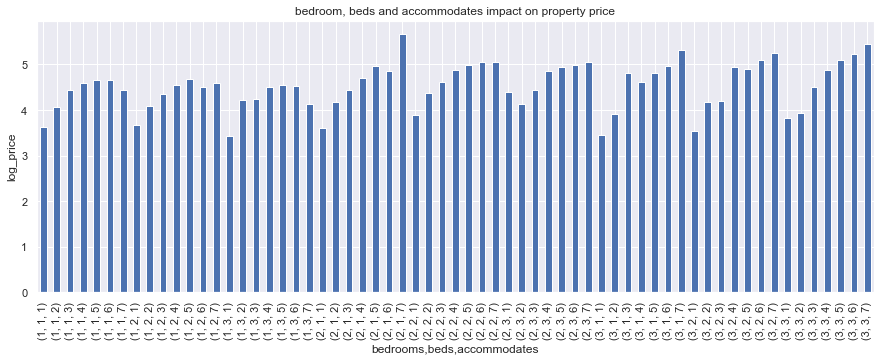

In [57]:
# bedroom, beds and accommodates impact on property price
price = data[['bedrooms','beds','accommodates','log_price']].groupby(['bedrooms','beds','accommodates']).mean()
price['log_price'].plot(kind='bar',ylabel='log_price',title='bedroom, beds and accommodates impact on property price')
price

price_per_room
bedrooms beds accommodates                
1        1    1                  45.022198
              2                  71.549855
              3                 100.200796
              4                 113.786805
              5                 131.954023
...                                    ...
3        3    3                  37.554617
              4                  51.197495
              5                  62.562022
              6                  74.362271
              7                  77.640075

[63 rows x 1 columns]

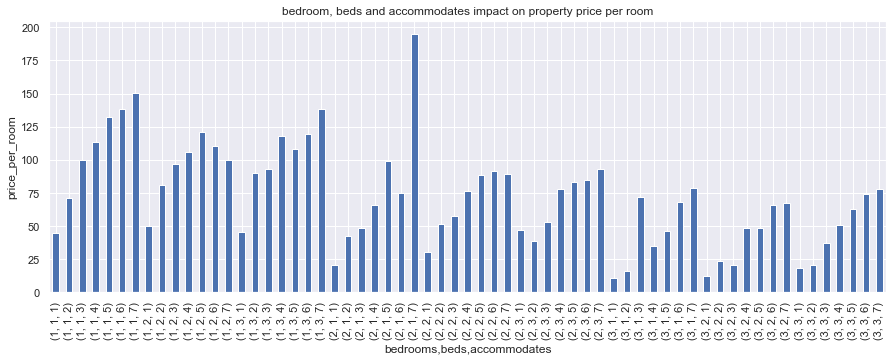

In [58]:
# bedroom, beds and accommodates impact on property price
price = data[['bedrooms','beds','accommodates','price_per_room']].groupby(['bedrooms','beds','accommodates']).mean()
price['price_per_room'].plot(kind='bar',ylabel='price_per_room',title='bedroom, beds and accommodates impact on property price per room')
price

In [59]:
# minimum nights stay distribution
data['minimum_nights'].value_counts(ascending=True)

6      986
5     4279
4     4365
7     9483
3    11956
2    20734
1    24552
Name: minimum_nights, dtype: int64

,price_per_room
minimum_nights,
1,74.113939
2,70.661000
3,76.819756
4,80.228959
5,75.317657
6,74.723698
7,73.150786


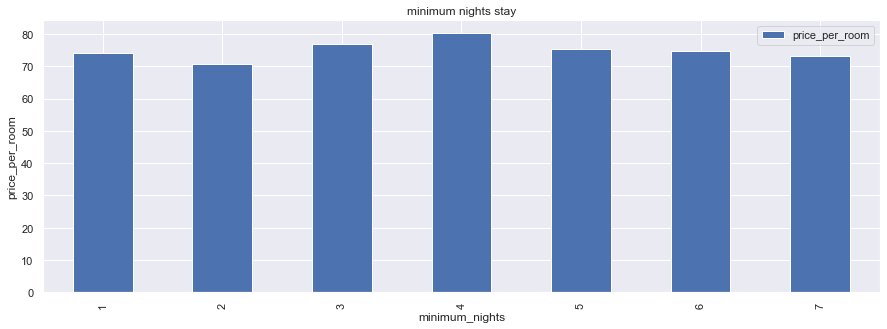

In [60]:
# minimum nights stay impact on price
price = data[['minimum_nights','price_per_room']].groupby(['minimum_nights']).mean()
price.plot(kind='bar',ylabel='price_per_room',title='minimum nights stay')
price

,bedrooms
minimum_nights,
1,1.240388
2,1.406434
3,1.530361
4,1.653379
5,1.584716
6,1.635903
7,1.474322


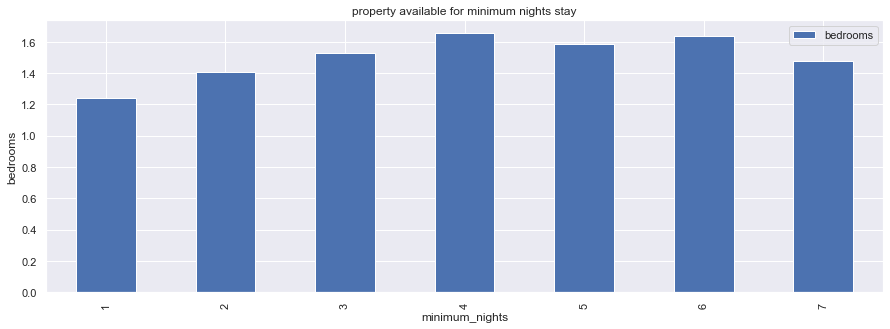

In [61]:
# how many property available for how many minimum nights stay
price = data[['minimum_nights','bedrooms']].groupby(['minimum_nights']).mean()
price.plot(kind='bar',ylabel='bedrooms',title='property available for minimum nights stay')
price

In [62]:
# Average of the review scores across all of a host's reviews
data['review_scores_rating'].value_counts(normalize=True)

0.0      0.310445
100.0    0.219305
98.0     0.044647
97.0     0.040875
93.0     0.039356
96.0     0.039185
95.0     0.036514
90.0     0.036291
80.0     0.036042
99.0     0.030005
94.0     0.025395
92.0     0.019684
91.0     0.016947
87.0     0.014760
88.0     0.012704
89.0     0.012534
60.0     0.009351
85.0     0.008618
86.0     0.006928
84.0     0.006208
83.0     0.005828
20.0     0.004597
70.0     0.003615
82.0     0.003261
73.0     0.002685
40.0     0.002593
81.0     0.001703
75.0     0.001428
67.0     0.001153
50.0     0.001048
76.0     0.001035
77.0     0.000917
78.0     0.000747
72.0     0.000537
65.0     0.000485
74.0     0.000354
68.0     0.000301
53.0     0.000262
71.0     0.000262
64.0     0.000249
55.0     0.000196
47.0     0.000170
69.0     0.000157
79.0     0.000144
30.0     0.000131
63.0     0.000105
52.0     0.000052
45.0     0.000052
66.0     0.000039
57.0     0.000039
62.0     0.000026
56.0     0.000013
33.0     0.000013
37.0     0.000013
Name: review_scores_rating, 

In [63]:
#the number of host has received Average of the review scores across all of a host's reviews
data[['number_of_reviews','review_scores_rating']].value_counts(normalize=True)

number_of_reviews  review_scores_rating
0                  0.0                     0.287866
1                  100.0                   0.073067
2                  100.0                   0.040731
3                  100.0                   0.025093
1                  0.0                     0.019789
                                             ...   
14                 73.0                    0.000013
                   77.0                    0.000013
15                 67.0                    0.000013
                   72.0                    0.000013
18                 77.0                    0.000013
Length: 808, dtype: float64

,log_price
review_scores_rating,
0.0,4.393118
20.0,4.321420
30.0,3.866970
33.0,4.060443
37.0,4.983607
40.0,4.228581
45.0,4.589733
47.0,4.370068
50.0,4.383736


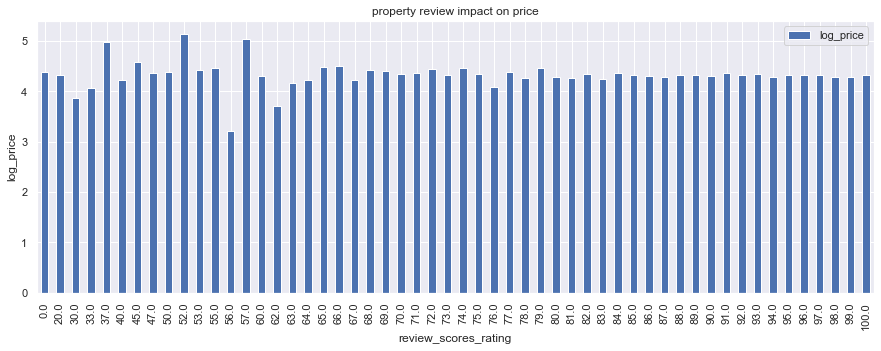

In [64]:
# review_scores_rating impact on price
price = data[['review_scores_rating','log_price']].groupby(['review_scores_rating']).mean()
price.plot(kind='bar',ylabel='log_price',title='property review impact on price')
price

In [65]:
# host allows instant bookings
data['instant_bookable'].value_counts(normalize=True)

0    0.63802
1    0.36198
Name: instant_bookable, dtype: float64

In [66]:
# instant bookings impact on price
data[['instant_bookable','log_price']].groupby(['instant_bookable']).mean()

,log_price
instant_bookable,
0,4.344229
1,4.337906


In [67]:
# host_country_status impact on price
data[['host_country_status','log_price']].groupby(['host_country_status']).mean()

,log_price
host_country_status,
Aboard,4.357461
Native,4.335406


In [68]:
# host_city impact on price
data[['host_city_status','log_price']].groupby(['host_city_status']).mean()

,log_price
host_city_status,
London,4.353822
Other,4.324622


In [69]:
# the average time it takes for the host to repsond
data['host_response_time'].value_counts(normalize=True)

unknown    0.519075
hour       0.252413
hours      0.100753
day        0.084841
days       0.042918
Name: host_response_time, dtype: float64

In [70]:
# the average time it takes for the host to repsond impace on price
data[['host_response_time','log_price']].groupby(['host_response_time']).mean()

,log_price
host_response_time,
day,4.419277
days,4.460428
hour,4.513220
hours,4.376850
unknown,4.229438


In [71]:
#The location of the property, as specified by the host
data['Property_Location'].value_counts(normalize=True)

other                0.382883
greater london       0.353978
london               0.231223
Other                0.002200
twickenham           0.001323
                       ...   
london w8            0.000013
london apprentice    0.000013
herne hill           0.000013
geffrye estate       0.000013
south tottenham      0.000013
Name: Property_Location, Length: 351, dtype: float64

,price_per_room
Property_Location,
york way estate,1000.000000
utuado,580.000000
mayfair,315.666667
potters edge at water yad,308.333333
United Kingdom,303.714286
...,...
anerley,20.000000
barkingside,20.000000
close sutton,19.000000


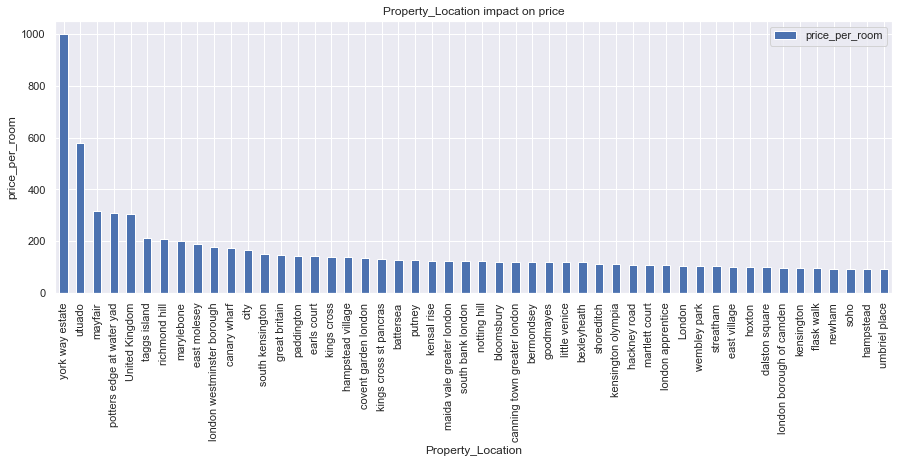

In [72]:
#the location of the property impact on price
property_price = data[['Property_Location','price_per_room']].groupby(['Property_Location']).mean()

#sorted price
property_price = property_price.sort_values(by='price_per_room',ascending=False)

property_price[:50].plot(kind='bar',ylabel='price_per_room',title='Property_Location impact on price')
property_price

,log_price
property,
aparthotel,4.527197
apartment,4.381842
barn,4.787928
bed and breakfast,4.130934
boat,4.554933
boutique hotel,4.882159
bungalow,3.993000
bus,3.198465
cabin,4.296621


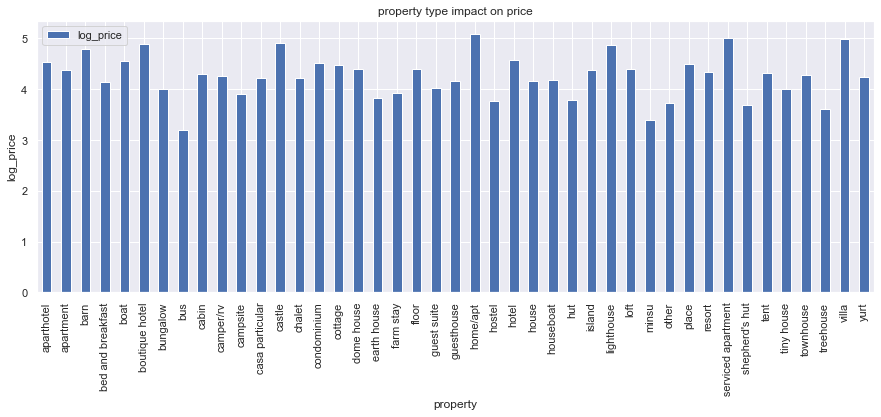

In [73]:
#the type of property impact on price
property_price = data[['property','log_price']].groupby(['property']).mean()
property_price.plot(kind='bar',ylabel='log_price',title='property type impact on price')
property_price

,price_per_room
property,
aparthotel,94.846154
apartment,76.415941
barn,111.666667
bed and breakfast,72.915776
boat,111.969744
boutique hotel,272.741482
bungalow,54.820862
bus,21.000000
cabin,73.263158


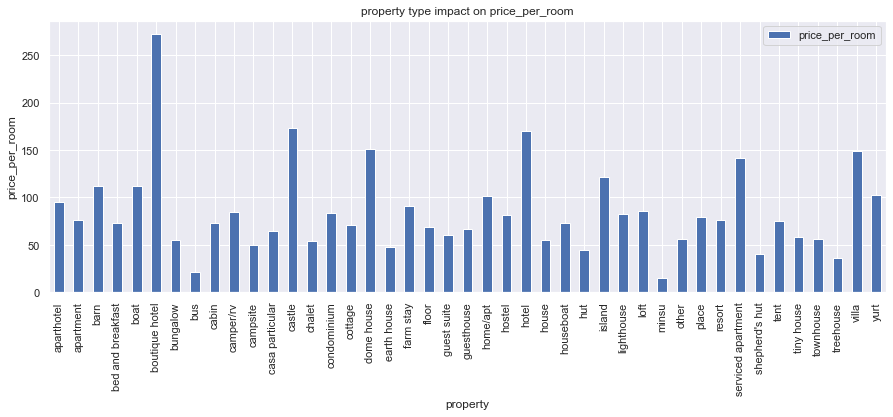

In [74]:
#the type of property impact on price
property_price = data[['property','price_per_room']].groupby(['property']).mean()
property_price.plot(kind='bar',ylabel='price_per_room',title='property type impact on price_per_room')
property_price

In [75]:
#the type of room
data['room_type'].value_counts(normalize=True)

Entire home/apt    0.549499
Private room       0.435846
Shared room        0.007518
Hotel room         0.007138
Name: room_type, dtype: float64

,log_price
room_type,
Entire home/apt,4.782380
Hotel room,4.585028
Private room,3.793199
Shared room,3.731400


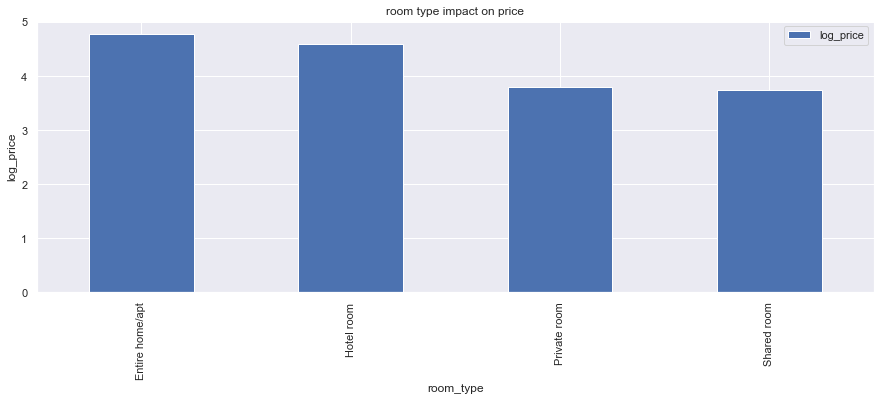

In [76]:
# the type of room impact on price
property_price = data[['room_type','log_price']].groupby(['room_type']).mean()
property_price.plot(kind='bar',ylabel='log_price',title='room type impact on price')
property_price

,price_per_room
room_type,
Entire home/apt,90.049961
Hotel room,112.788960
Private room,53.004734
Shared room,68.635889


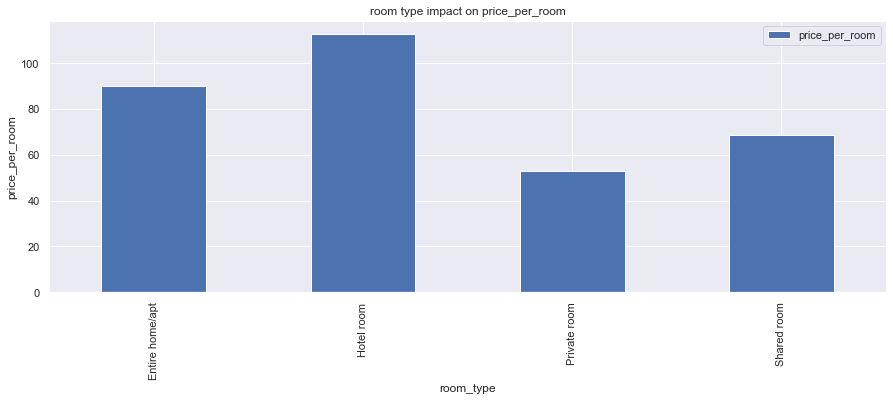

In [77]:
# the type of room impact on price
property_price = data[['room_type','price_per_room']].groupby(['room_type']).mean()
property_price.plot(kind='bar',ylabel='price_per_room',title='room type impact on price_per_room')
property_price

,price_per_room
host_verifications_status,
Not Verified,73.879619
Verified,100.721461


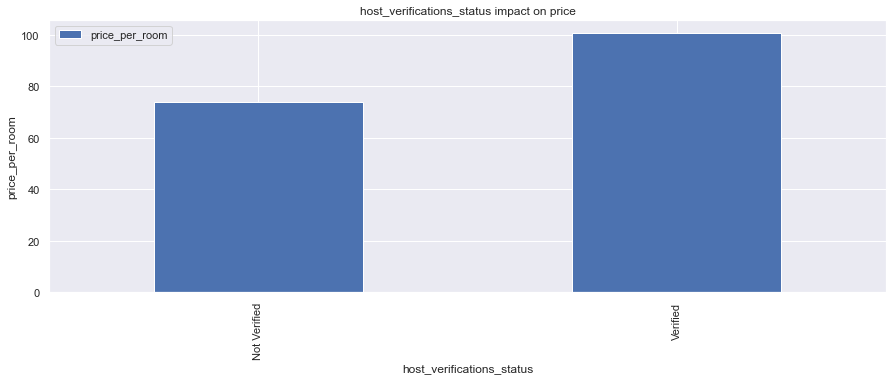

In [78]:
# host verification impact on price
property_price = data[['host_verifications_status','price_per_room']].groupby(['host_verifications_status']).mean()
property_price.plot(kind='bar',ylabel='price_per_room',title='host_verifications_status impact on price')
property_price

,price_per_room
number_of_amenities,
1,83.451262
2,69.006518
3,71.491418
4,64.546078
5,62.294250
...,...
61,51.833333
63,67.083333
64,96.500000


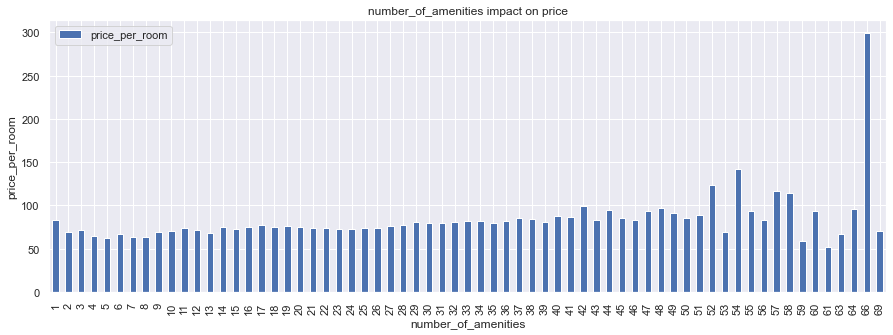

In [79]:
# number_of_amenities impact on property price
property_price = data[['number_of_amenities','price_per_room']].groupby(['number_of_amenities']).mean()
property_price.plot(kind='bar',ylabel='price_per_room',title='number_of_amenities impact on price')
property_price

In [80]:
# Entertainment amenity provided by host
data['Entertainment'].value_counts(normalize=True)

1    0.689582
0    0.310418
Name: Entertainment, dtype: float64

In [81]:
#Kitchen and dining amenity provided by host
data['Kitchen and dining'].value_counts(normalize=True)

1    0.936298
0    0.063702
Name: Kitchen and dining, dtype: float64

In [82]:
#Internet and office amenity provided by host
data['Internet and office'].value_counts(normalize=True)

1    0.97175
0    0.02825
Name: Internet and office, dtype: float64

In [83]:
#Bathroom amenity provided by host
data['Bathroom'].value_counts(normalize=True)

1    0.86847
0    0.13153
Name: Bathroom, dtype: float64

In [84]:
#Bedroom and laundry amenity provided by host
data['Bedroom and laundry'].value_counts(normalize=True)

1    0.937437
0    0.062563
Name: Bedroom and laundry, dtype: float64

In [85]:
#safety amenity provided by host
data['safety'].value_counts(normalize=True)

0    0.664659
1    0.335341
Name: safety, dtype: float64

In [86]:
#Facilities amenity provided by host
data['Facilities'].value_counts(normalize=True)

1    0.918263
0    0.081737
Name: Facilities, dtype: float64

In [87]:
#Heating and cooling amenity provided by host
data['Heating and cooling'].value_counts(normalize=True)

1    0.944051
0    0.055949
Name: Heating and cooling, dtype: float64

,log_price
number_of_nearby,
1,4.219790
2,4.348150
3,4.389679
4,4.453980
5,4.469388
6,4.509307
7,4.560016
8,4.653790
9,4.610368


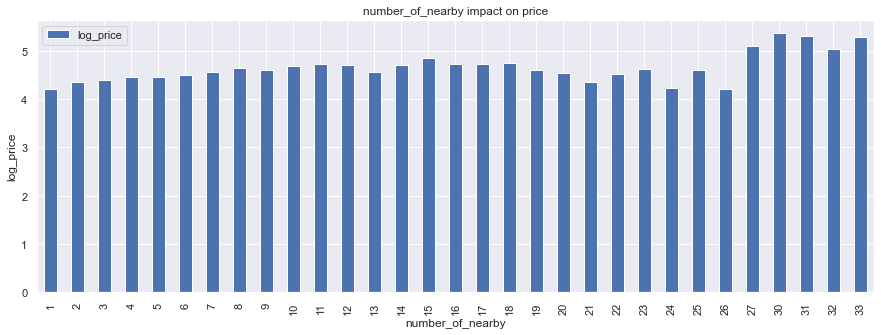

In [88]:
# number_of_nearby impact on property price
property_price = data[['number_of_nearby','log_price']].groupby(['number_of_nearby']).mean()
property_price.plot(kind='bar',ylabel='log_price',title='number_of_nearby impact on price')
property_price

# EDA Conclusion

- Properties are available in all types. However, Most properties has 1 bedroom and if we increased number of bedrooms property’s price decreased. 
- Minimum Night stay does not provide variance on price. However, 4 Night stay is popular.
- 21.93% of host achieved 100% reviews. However, 07.30% of host has 1 review recorded.
- 63.80% of host allows instant bookings.
- Property Location has high impact on property price. Where, barn, boutique hotel, castle, home/apt, lighthouse, serviced apartment and villa has high prices and boutique hotel, castle has costly rooms. 'york way estate' is a location with the highest price of the property.
- Entire Apartment or house has high price property as compared to other. Whereas Hotel rooms are costly rooms.
- Verified Host has high priced property.
- When host provides the greater number of  amenities, the price of property is increases as well.
    68.87% host provides Entertainment, 93.60% Kitchen and dining, 97.14% Internet and office, 86.71% Bathroom, 93.63% Bedroom and laundry, 66.46% safety, 91.69% Facilities, 94.26% Heating and cooling.
- The nearby location is effective for property prices.


In [89]:
data.to_csv(data_path+'airbnb_listings_information_processed.csv', index=False)